In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from IPython.display import Image as IPyImage # Replace references to Image with IPyImage (may not even need this)
import os
import random

os.environ["NUMEXPR_MAX_THREADS"] = str(os.cpu_count()) # suppresses pandas error
import pandas as pd

# to avoid Out of Memory error
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
class MOVi_Dataset_SmartSelect(Dataset):
    def __init__(self, 
                 root,
                 metadata_root="../dataset_metadata",
                 split = 'train' or 'test', 
                 n_frames = 8,
                 n_samples = 100,
                 min_modal_pixels_visible = 10,
                 min_occ_rate = 0.5,
                 max_occ_rate = 0.9,
                 #box_format = 'xywh'
                 ):
        """
        Initialize the MOVi dataset loader, with Dataset Smart selection.
        Inherits functions from the basic MOVi_Dataset.
        Smart Selection works by ensuring certain conditions are met: modal_mask is not all zero, i.e., the object is not fully occluded,
        the occlusion rate is high enough to learn something meaningful about completion etc. This uses dataset metadata.
        This dataloader picks a random scene (video sample), a random object, and a random camera view.
        It will then load all frames from the chosen video and camera view, for its chosen object.
        
        Args:
            root: The root folder that holds the unzipped sample folders
            split: Which root subfolder to draw from (train or test)
            n_frames: How many consecutive frames to load. Defaults to 8.
            n_samples: How many samples to load. This is equal to the number of objects you want to load. Defaults to 100.
            min_modal_pixels_visible (int): How many object pixels have to be visible in the modal image to be accepted. In the case of video,
                this criterion is applied on the average number of modal pixels visible. Defaults to 10.
            min_occ_rate (float): Minimum object occlusion rate. This the ratio of modal pixels/number of amodal pixels. 0 to 1,
                defaults to 0.5. For videos, this is the average across N_FRAMES.
            max_occ_rate (float): Maximum object occlusion rate to accept. 0 to 1, defaults to 0.9. Must be bigger than min_occ_rate.
            
        The dataset returned will be in the form of a dictionary, containing keys:
        'frames': RGB content, tensor with 3 channels, depth = n_frames (consecutive frames)
        'depths': modal depths, tensor, binary single channel
        'modal_masks': modal masks (occluded), binary single channel 
        'amodal_masks': amodal masks, binary single channel
        'amodal_content': RGB content, tensor with 3 channels
        'metadata': A metadata dictionary, offering info on scene, camera, object ID, as well as the number of objects in the scene.
            
        """
        print('Dataset init on', split)

        self.split = split
        self.top_dir = f'{root}/{split}/'
        print('Init data top dir:', self.top_dir)

        #self.box_format = box_format

        # Get directories in data_dir/train-test
        self.scenes = [entry for entry in os.listdir(self.top_dir) if os.path.isdir(os.path.join(self.top_dir, entry))]
        
        assert n_frames <= N_TOT_FRAMES
        self.n_frames = n_frames
        self.n_samples = n_samples

        assert min_occ_rate < max_occ_rate
        
        # Perform dataset selection
        self.image = False
        if n_frames == 1:
            # Load image metadata
            df = pd.read_csv(f"{metadata_root}/{split}_per_frame_metadata.csv", index_col=0)
            # Apply criteria
            df_select = df[(df['scene_id'].isin(self.scenes)) &
                        (df['occ_rate'] >= min_occ_rate) &
                        (df['occ_rate'] <= max_occ_rate) &
                        (df['modal_n_pixels_foreground'] >= min_modal_pixels_visible)].copy().reset_index(drop=True)
            self.image = True
        else:
            # loading video data
            self.image = False
            df = pd.read_csv(f"{metadata_root}/{split}_video_metadata.csv", index_col=0)
            # Apply criteria
            df_select = df[(df['scene_id'].isin(self.scenes)) &
                        (df['avg_occ_rate'] >= min_occ_rate) &
                        (df['avg_occ_rate'] <= max_occ_rate) &
                        (df['avg_modal_n_pixels_foreground'] >= min_modal_pixels_visible)].copy().reset_index(drop=True)
            
        n_available = len(df_select)
        if n_available < n_samples:
            print("WARNING: Your requested n_samples is smaller than the number of samples meeting your criteria. Chance of getting duplicates.")
        self.df_select = df_select


    def __len__(self):
        # In theory this could be like n_scenes*n_objects
        # To get total number of (cam-invariant) objects
        return self.n_samples


    def __getitem__(self, idx):
        """
        Selects item only if it fulfils the criteria
        """
        df = self.df_select.copy()
        # Select a random scene - camera - object sample from the selected
        # this is now a dictionary
        random_sample = df.iloc[np.random.choice(df.index)]

        # Write out scene - camera - obj choice
        random_scene = random_sample['scene_id']
        # Random camera - all scenes should have cam 0000 to cam 0005
        cam_id = random_sample['cam_id']
        target_object_id = 'obj_{}'.format(str(random_sample['obj_id']).zfill(4))

        # Now select frames
        if self.image:
            # Select a single random frame fulfiling the criteria
            start = random_sample['frame_id']
            stop = start + 1
        else:
            # Select random frames for video
            start = random.randint(0, 24-self.n_frames)
            stop = start + self.n_frames
        
        frames, depths, modal_masks, amodal_segs, amodal_content = self.load_camera(random_scene, cam_id=cam_id, 
                                                                                    obj_id=target_object_id, 
                                                                                    start=start, stop=stop)
        # Inflate modal masks to 255
        # No need - already done in load camera!!
        # modal_masks = modal_masks*255
        # modal_masks = modal_masks.to(torch.uint8)
        # Select the integer obj id
        obj_id_int = int(str(target_object_id).split(sep="_")[-1]) # get integer obj ID
        modal_masks = (modal_masks == obj_id_int).int() # filter into a binary modal mask for the object

        # Check if modal_mask contains any nonzero pixels
        # We reject the sample if the object is fully occluded (modal mask all zero)
        sample = {
            'frames': frames,
            'depths': depths,
            'modal_masks': modal_masks,
            'amodal_masks': amodal_segs,
            'amodal_content': amodal_content,
            'metadata': random_sample.to_dict()
        }
        return sample
    
    # Helper functions
    def load_camera(self, scene_id, cam_id, obj_id, start, stop):

        # Load the target objects 
        modal_segs = self.load_cam_frames(scene_id, 
                                            cam_id,
                                            start, stop,
                                            'modal_masks')
        
        # Inflate modal_segs from float to integers
        # Should give one integer in range(0, Nobj-1)
        modal_segs = modal_segs*255
        modal_segs = modal_segs.int()

        # Load frames corresponding to inputs
        frames = self.load_cam_frames(scene_id, 
                                      cam_id, 
                                      start, 
                                      stop, 
                                      'rgba_full')[:-1] #drop the A 

        # Load depth (though we will have to replace with Depth-Anything-V2 estimates)
        depths = self.load_cam_frames(scene_id, cam_id, start, stop, 'depth_full')

        amodal_segs = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'amodal_segs')
        amodal_content = self.load_obj_frames(scene_id, cam_id, obj_id, start, stop, 'content')
        
        return frames, depths, modal_segs, amodal_segs, amodal_content
    
    def all_objects(self, pth):
        """
        Given a path, get the objects at that path using regex
        """
        #print('looking for all objects at', pth)
        
        # Find all matches
        matches = []
        for fname in sorted(os.listdir(pth)):
            if 'obj_' in fname:
                matches.append(fname)

        #print(matches)
        return matches # list of ['obj_0001', 'obj_0009',...]
    
    def load_cam_frames(self, scene, 
                    cam_idx,
                    start, stop, 
                    modality):
        """
        One load-frames loads camera-level stuff (rgb, depth)
        The other one loads object-level stuff (scene/cam/obj_i/amodal_mask or content)
        """
        # Load frame range
        imgs = []
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            # loads train/scene_id/cam_id/frames_or_depth_or_modal/frame_id.png
            if modality == 'modal_masks':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))
            
            if modality == 'rgba_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans

            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/depth_{str(i).zfill(5)}.tiff'
                tens = totensor(Image.open(load_file).convert('RGB')) # RGB, 3 chans
                
            tens = totensor(Image.open(load_file))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)

        return tensor
    
    def load_obj_frames(self, scene, 
                    cam_idx,
                    object_idx,
                    start, stop, 
                    modality):
        """
        This loaded loads object-level stuff
        """
        # Load frame range
        imgs = []
        # amodal_segs, content, rgba_full, modal_masks, depth_full
        suffix = '.png'

        totensor = ToTensor()

        for i in range(start, stop):
            if modality == 'amodal_segs':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/segmentation_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file))

            if modality == 'content':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
                
            if modality == 'depth_full':
                load_file = f'{self.top_dir}/{scene}/{cam_idx}/{object_idx}/rgba_{str(i).zfill(5)}{suffix}'
                tens = totensor(Image.open(load_file).convert('RGB'))
            imgs.append(tens)

        tensor = torch.stack(imgs, dim = 1)
        return tensor

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
data_dir = '/usr/workspace/dssi-dsc/subset_data'
metadata_dir = '/g/g19/pawl1/metadata/groupj_llnl/dataset_metadata'

In [5]:
batch_size = 4
n_workers = 1

# Define some check variables
N_SCENES_DOWNLOADED_TRAIN = 170
N_SCENES_DOWNLOADED_TEST = 39
N_TOT_FRAMES = 24
N_MAX_TRIES = 10 # for filtering - will try 10 times to find sample that is on camera

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_SmartSelect(
                 data_dir,
                 metadata_dir,
                 split = 'train', 
                 n_frames = 8,
                 n_samples = 1,
                 min_modal_pixels_visible = 10,
                 min_occ_rate = 0.5,
                 max_occ_rate = 0.9
)

train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_SmartSelect(
                 data_dir,
                 metadata_dir,
                 split = 'test', 
                 n_frames = 8,
                 n_samples = 1,
                 min_modal_pixels_visible = 10,
                 min_occ_rate = 0.5,
                 max_occ_rate = 0.9
)

val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)

Dataset init on train
Init data top dir: /usr/workspace/dssi-dsc/subset_data/train/
Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


In [13]:
class conv3d_inplace_spatial(nn.Module):
    def __init__(self, in_channels, out_channels, pooling_function, activation=nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(out_channels),
            nn.GELU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)


class Upscale(nn.Module):
    def __init__(self, scale_factor=(1, 2, 2), mode='trilinear', align_corners=False):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Video(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.mpool_2 = nn.MaxPool3d((1, 2, 2))

        # Down path
        self.down1 = conv3d_inplace_spatial(in_channels, 32, self.mpool_2)
        self.down2 = conv3d_inplace_spatial(32, 64, self.mpool_2)
        self.down3 = conv3d_inplace_spatial(64, 128, self.mpool_2)
        self.down4 = conv3d_inplace_spatial(128, 256, self.mpool_2)

        # Up path
        self.upscale_2 = Upscale()
        self.up1 = conv3d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv3d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv3d_inplace_spatial(128, 32, self.upscale_2)
        
        self.up4_amodal_mask = conv3d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv3d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?
        
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)

        return x1, x2, x3, x4

    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content

    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w)
        """
        b, c, frames, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
    
    def forward(self, batch):
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss
        
        metrics = calculate_metrics(logits_amodal_mask, amodal_mask_labels, logits_amodal_content, amodal_content_labels)
        metrics["loss"] = loss.item()
        
        return loss, metrics
    
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        
        return mask_loss, content_loss

In [14]:
def IOU(preds, targets, smooth=1e-7):
    """
    IoU (Intersection over Union) - 
    Intersection of Predicted and True masks
    over Union of intersection and true
    """
    preds = preds.sigmoid().round()
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [23]:
batch = next(iter(train_dataloader))

In [32]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

LPIPS = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)

def prepare_for_lpips(x):
    """
    Converts logits to the correct format for torchmetrics LPIPS.
    - Ensures float32, [0, 1], and 3 channels.
    Args:
        x: Tensor (batch, channels, frames, H, W) or (batch, channels, H, W)
    Returns:
        Tensor (batch, 3, frames, H, W) or (batch, 3, H, W), float32 in [0, 1]
    """
    # If input is uint8, assume [0, 255] and scale
    if x.dtype == torch.uint8:
        x = x.float() / 255.0
    # If input is in [-1, 1], convert to [0, 1]
    if x.min() < 0:
        x = (x + 1) / 2.0
    # Ensure 3 channels
    if x.shape[1] > 3:
        x = x[:, :3]
    elif x.shape[1] < 3:
        # Simple repeat if grayscale
        x = x.repeat(1, 3, *([1] * (x.dim() - 2)))
    return x

def lpips_over_frames_torchmetrics(preds, targets, lpips_func):
    """
    Computes average LPIPS over frames and batch using torchmetrics LPIPS.
    Remember, lower LPIPS means higher perceptual similarity (optimal is zero)
    Args:
        lpips_metric: An instance of torchmetrics.LearnedPerceptualImagePatchSimilarity.
        preds: Tensor of shape (batch, channels, frames, H, W)
        targets: Tensor of same shape as preds.
    Returns:
        Scalar tensor: average LPIPS over all frames and batch.
    """
    # Goes from logits to range of [-1, 1] expected by LPIPS
    preds = prepare_for_lpips(preds)
    targets = prepare_for_lpips(targets)
    batch, channels, num_frames, H, W = preds.shape
    scores = []
    for t in range(num_frames):
        pred_frame = preds[:, :, t, :, :]    # (batch, 3, H, W)
        target_frame = targets[:, :, t, :, :]
        score = lpips_func(pred_frame, target_frame)  # (batch,) or scalar
        if score.dim() == 0:
            score = score.unsqueeze(0)  # Make it (1,)
        scores.append(score)
    scores = torch.stack(scores, dim=1)  # (batch, frames)
    return scores.mean()

In [33]:
def calculate_metrics(pred_mask_logits, true_amodal_mask, logits_pred_content, true_rgb_content, eps = 1e-7):
    with torch.no_grad():
        iou = IOU(pred_mask_logits, true_amodal_mask)
        lpips = lpips_over_frames_torchmetrics(logits_pred_content.sigmoid(), true_rgb_content, LPIPS)
        
        return {"iou": iou.item(), 
                "LPIPS": lpips.item()}

In [34]:
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

def batch_to_device(batch, device):
    for key, value in batch.items():
        if(key != 'metadata'):
            batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the 
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, train_dataloader, val_dataloader, n_epochs, device, stop_loss, stop_iou):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in range(n_epochs):
        print('Starting Epoch', epoch)
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%1 == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)
          
        if float(valid_epoch_metrics['loss']) < stop_loss:
            print(f"Low validation loss of {float(valid_epoch_metrics['loss'])}, stopping early.")
            break
        
        train_value = train_epoch_metrics.get('iou', "N/A")
        val_value = valid_epoch_metrics.get('iou', "N/A")
        
        if train_value > stop_iou and val_value > stop_iou:
            print(f"High IoUs: training: {train_value:.2f}, validation: {val_value:.2f}, stopping early.")
            break

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])
    
    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)

In [36]:
mask_content_preds = True
n_epochs = 100
learning_rate = 1e-3

model = Unet_Video(in_channels = 4).to(device) # ModalMask+RGB -> AmodalMask+AmodalContent

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

res_list = train(model, optim, train_dataloader, val_dataloader, n_epochs = n_epochs, device = device, stop_loss = 0.043, stop_iou = 0.5)

Starting Epoch 0
Epoch 0 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 0   |   Training |   Validation |
+====================+============+==============+
| iou                | 0.00706315 |   6.4813e-12 |
+--------------------+------------+--------------+
| LPIPS              | 0.66357    |   0.146349   |
+--------------------+------------+--------------+
| loss               | 0.909634   |   0.611426   |
+--------------------+------------+--------------+
Starting Epoch 1
Epoch 1 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 1   |   Training |   Validation |
+====================+============+==============+
| iou                |  0.0181971 |  8.96861e-11 |
+--------------------+------------+--------------+
| LPIPS              |  0.584915  |  0.120263    |
+--------------------+------------+--------------+
| loss               |  0.917872  |  0.594867    |
+--------------------+------------+--------------+
Starting Epoch

In [37]:
torch.save(model.state_dict(), 'task2_redo_model_weights.pth')
torch.save(model, 'task2_redo_model.pth')

In [38]:
def make_single_model_comparison_grid(scene_rgb, scene_modal_mask,
                               gt_amodal_rgb, gt_amodal_mask,
                               pred_amodal_rgb, pred_amodal_mask,
                               padding=2, pad_value=127, n_per_row=3, idx = 0):
    """
    Makes a grid_tensor for a 4 row by 2 column video
    Compares inputs and ground truth to output from two models
    """
    # Select which video from the batch
    scene_rgb = scene_rgb[idx]
    scene_modal_mask = scene_modal_mask[idx]
    gt_amodal_rgb = gt_amodal_rgb[idx]
    gt_amodal_mask = gt_amodal_mask[idx]
    pred_amodal_rgb = pred_amodal_rgb[idx]
    pred_amodal_mask = pred_amodal_mask[idx]
    
    # Infer frames from the second dim
    n_frames = scene_rgb.shape[1]
    print(n_frames)
    grid_tensors = []
    for i in range(n_frames):
        # Select the i-th frame for each tensor
        scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
        scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
        gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
        gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
        pred_rgb_frame = pred_amodal_rgb[:, i]            # (3, H, W)
        pred_amask_frame = pred_amodal_mask[:, i]          # (1 or 3, H, W)
        
        # If mask is single-channel, repeat to 3 channels for visualization
        if scene_mask_frame.shape[0] == 1:
            scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
        if gt_mask_frame.shape[0] == 1:
            gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
        if pred_amask_frame.shape[0] == 1:
            pred_amask_frame = pred_amask_frame.repeat(3, 1, 1)

            
        # Top row: Scene Mask | True amodal mask | Model amodal 
        row1 = [scene_mask_frame, gt_mask_frame, pred_amask_frame]
        # Middle row: Scene RGB | GT amodal RGB | Model amodal RGB
        row2 = [scene_rgb_frame, gt_rgb_frame, pred_rgb_frame]
        # # Bottom row: Pred Mod1 amodal RGB | Pred Mod1 amodal mask
        # row3 = []
        # # Bottom row: Pred Mod2 amodal RGB | Pred Mod2 amodal mask
        # row4 = []

        # Stack all rows horizontally (2 columns per row, 4 rows)
        grid = row1 + row2  # [8 tensors]
        # nrow is num of images per row
        grid_img = make_grid(grid, nrow=n_per_row, padding=padding, pad_value=pad_value)
        grid_tensors.append(grid_img)
    return grid_tensors


# Quick video
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})

def make_grid_video_with_titles(grid_tensors, 
                                panel_titles=[['Input Modal Mask', 'True Amodal Mask', '3D-Unet\nPred Amodal Mask'],
                                              ['Input RGB', 'True Amodal RGB', '3D-Unet\nPred Amodal RGB']], 
                                nrows=2, ncols=3, figsize=(12, 8), 
                                title_fontsize=12,
                                interval=200, save_path=None):
    """
    Writes a 2-column, 3-row video. 

    grid_tensors: list of torch.Tensor, each of shape (3, H, W), values in [0,1] or [0,255]
    panel_titles: 2D list of strings, shape (nrows, ncols)
    interval: time between frames in ms
    save_path: if not None, saves animation to this path (e.g., 'output.mp4')
    """
    # Prepare figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes if isinstance(axes, np.ndarray) else np.array([[axes]])

    assert np.array(panel_titles).shape == axes.shape

    # Compute panel height and width from first frame
    img = grid_tensors[0].cpu()
    # Always convert to uint8 for display
    if img.dtype != torch.uint8:
        img = (img * 255).clamp(0, 255).byte()
    img_np = img.permute(1, 2, 0).numpy()  # (H, W, 3)

    # Debug: print min/max for first frame
    print(f"First frame min: {img_np.min()}, max: {img_np.max()}, dtype: {img_np.dtype}")

    H, W, _ = img_np.shape
    panel_h = H // nrows
    panel_w = W // ncols

    # Set titles and initialize images
    ims = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            ax = axes[i, j]
            ax.set_title(panel_titles[i][j], fontsize=title_fontsize)
            ax.axis('off')
            # Dummy initial image
            panel = img_np[i*panel_h:(i+1)*panel_h, j*panel_w:(j+1)*panel_w]
            im = ax.imshow(panel)
            row.append(im)
        ims.append(row)

    def update(frame_idx):
        img = grid_tensors[frame_idx].cpu()
        if img.dtype != torch.uint8:
            img = (img * 255).clamp(0, 255).byte()
        img_np = img.permute(1, 2, 0).numpy()
        for i in range(nrows):
            for j in range(ncols):
                y0, y1 = i * panel_h, (i + 1) * panel_h
                x0, x1 = j * panel_w, (j + 1) * panel_w
                panel = img_np[y0:y1, x0:x1]
                ims[i][j].set_data(panel)
        return sum(ims, [])

    ani = animation.FuncAnimation(fig, update, frames=len(grid_tensors), interval=interval, blit=False)
    plt.tight_layout()
    if save_path is not None:
        ani.save(save_path, writer='ffmpeg')
    else:
        plt.show()

In [40]:
sample = next(iter(val_dataloader))

In [107]:
test_dataset = MOVi_Dataset_SmartSelect(
                 data_dir,
                 metadata_dir,
                 split = 'test', 
                 n_frames = 8,
                 n_samples = 4,
                 min_modal_pixels_visible = 10,
                 min_occ_rate = 0.5,
                 max_occ_rate = 0.9
)

test_dataloader = DataLoader(test_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)

Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


In [133]:
samples = iter(test_dataloader)
sample = next(samples)

In [134]:
model.eval()
with torch.no_grad():
    inputs = torch.cat((sample['frames'], sample['modal_masks']), dim=1).to(device)
    
    # logits_amodal_mask, logits_amodal_content = model._forward_predict(inputs)
    logits_amodal_mask, logits_amodal_content = model.encode_decode(inputs)
    
    pred_mask = torch.sigmoid(logits_amodal_mask).round().cpu()
    pred_content = logits_amodal_content.sigmoid().cpu() * pred_mask

8
First frame min: 0, max: 255, dtype: uint8


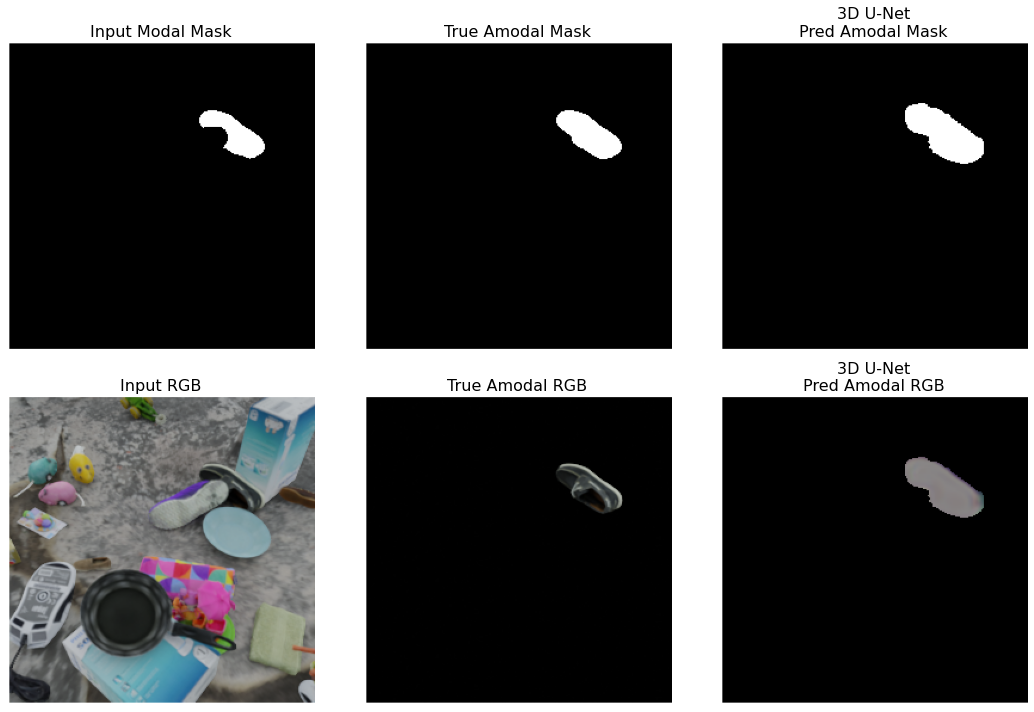

In [135]:
grid_tensors = make_single_model_comparison_grid(scene_rgb=sample['frames'], 
                           scene_modal_mask=sample['modal_masks'],
                               gt_amodal_rgb=sample['amodal_content'], 
                               gt_amodal_mask=sample['amodal_masks'],
                               pred_amodal_rgb=pred_content, 
                               pred_amodal_mask=pred_mask, n_per_row=3, idx = 1)

metadata = sample['metadata'] # working with SmartSelect dataloader
# Your outpath
outpath = "task2figure.gif"
make_grid_video_with_titles(grid_tensors,
                            panel_titles=[['Input Modal Mask', 'True Amodal Mask', '3D U-Net\nPred Amodal Mask'],
                                              ['Input RGB', 'True Amodal RGB', '3D U-Net\nPred Amodal RGB']],
                            nrows=2, ncols=3,
                            interval=200, 
                            save_path=outpath, figsize=(15, 10), title_fontsize=16)

In [137]:
LPIPS = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to('cpu')
calculate_metrics(logits_amodal_mask[1:2].cpu(), sample['amodal_masks'][1:2], logits_amodal_content[1:2].cpu(), sample['amodal_content'][1:2])

{'iou': 0.5891899466514587, 'LPIPS': 0.3719896674156189}